In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
from pandas.io.json import json_normalize
import seaborn as sns
sns.set_context('talk')

The 'export.json' file has two levels before getting to the data layer. Then, for each entry, we get `d`, `l` ,and `g`. The `l` object has the coordinates, the `g` object is some sort of tag, and `d` is where all data is stored, inclusively a copy of the coordinates. However, it does not seem the coordinates are always copied, hence, is ti safer to use them from `l`.

In [2]:
with open('./Files/export.json') as f:
    data = json.load(f)

In [3]:
## Ignore the first two hierarchical layers
tempj = data['campaign-markers']['data']

In [4]:
#To flatten the remaining json and convert it into a pandas dataframe (easier to manipulate, imo)
data = pd.json_normalize(tempj)

In [5]:
data.head()

,g,d.parameters.campaign,d.parameters.locationSurrounding,d.parameters.team,d.parameters.motive,d.parameters.targetGroup,d.coordinates._latitude,d.coordinates._longitude,d.deletedAt._seconds,d.deletedAt._nanoseconds,...,d.location._latitude,d.location._longitude,d.removedBy,d.updatedAt._seconds,d.updatedAt._nanoseconds,d.updatedBy,d.state,l._latitude,l._longitude,d.deletedBy
0,u1wbxq8usv,Bürgerschaftswahl Hamburg 2020,"[Wohnen, Einkaufen, Durchgangsstrasse]",Team West,Lina,"[Fußgänger, Radfahrer, Autofahrer]",53.561896,9.812026,1.582969e+09,456000000.0,...,53.561896,9.812026,OFdUjpbNLXZoeRPWB5YjxRxjzRH3,1580044678,280000000,OFdUjpbNLXZoeRPWB5YjxRxjzRH3,removed,53.561896,9.812026,NaN
1,u284phpwud,Kommunalwahl München 2020,NaN,NaN,NaN,NaN,48.187206,11.568115,1.584640e+09,136000000.0,...,48.187206,11.568115,qk3RwE5WEUNbPk85eTf18Lu4JY32,1580056006,182000000,ihPzNAGmQdatZW7rFD8q3cNubuS2,removed,48.187206,11.568115,NaN
2,u281zdht22,NaN,[Strasse],NaN,Umwelt + Wohnen,"[Autofahrer, Fußgänger, Radfahrer]",48.132008,11.585783,NaN,NaN,...,NaN,NaN,NaN,1578829812,698000000,psfZAjTSV5Stlfwj4Og2ihxSVqn1,active,48.132008,11.585783,NaN
3,u1x0ebphc5,Bürgerschaftswahl Hamburg,NaN,NaN,Hafen + Wohnen,NaN,53.526223,10.018206,1.582981e+09,978000000.0,...,53.526223,10.018206,NISiXJvou2OIg0ygvLTQni8z6Gm1,1579958449,348000000,vRs7bqLgbaZOrY9viLatNAzZrgD2,removed,53.526223,10.018206,NaN
4,u284hyjp09,Kommunalwahl München 2020,[Wohnen],Team Dachau,Mobilität + Umwelt,"[Radfahrer, Fußgänger]",48.198231,11.465639,1.584808e+09,182000000.0,...,48.198231,11.465639,HgM385Ff84YmItF4qjVY8OGvuih2,1582474831,797000000,RwRvY0PtsoYOgcf3a7xxHfrV7YA3,removed,48.198231,11.465639,NaN


In [6]:
## Cleanup the d.parameters.campaign column a little bit. Add a new column called campaign which is the cleaned version. Remove trailing and leading chars we might not want
data['campaign'] = data['d.parameters.campaign']
data['campaign'] = data['campaign'].astype('str')
data['campaign'] = data['campaign'].map(lambda x: x.lstrip('[').rstrip(']'))
data['campaign'] = data['campaign'].map(lambda x: x.lstrip('\'').rstrip('\''))

In [7]:
def readExportToPd(file='./Files/export.json'):
    """
    Reads an export file and returns a pandas dataframe.
    """
    
    with open(file) as f:
        data = json.load(f)
        
    ## Ignore the first two hierarchical layers
    tempj = data['campaign-markers']['data']
    
    #To flatten the remaining json and convert it into a pandas dataframe (easier to manipulate, imo)
    data = pd.json_normalize(tempj)
    
    ## Cleanup the d.parameters.campaign column a little bit. Add a new column called campaign which is the cleaned version. Remove trailing and leading chars we might not want
    data['campaign'] = data['d.parameters.campaign']
    data['campaign'] = data['campaign'].astype('str')
    data['campaign'] = data['campaign'].map(lambda x: x.lstrip('[').rstrip(']'))
    data['campaign'] = data['campaign'].map(lambda x: x.lstrip('\'').rstrip('\''))
    
    return data

In [8]:
#Save to csv
data.to_csv('./Files/jsonflattened.csv', index=False)
#Same, but json
data.to_json('./Files/jsonflattened.json')

In [9]:
## Mini version, just for plotting
form = data[['l._longitude', 'l._latitude', 'd.parameters.team', 'campaign']]
form.columns = ['longitude', 'latitude', 'team', 'campaign']

In [10]:
form.head()

,longitude,latitude,team,campaign
0,9.812026,53.561896,Team West,Bürgerschaftswahl Hamburg 2020
1,11.568115,48.187206,NaN,Kommunalwahl München 2020
2,11.585783,48.132008,NaN,nan
3,10.018206,53.526223,NaN,Bürgerschaftswahl Hamburg
4,11.465639,48.198231,Team Dachau,Kommunalwahl München 2020


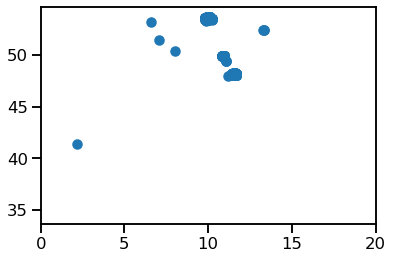

In [11]:
plt.scatter(form['longitude'], form['latitude'])
plt.xlim(0, 20)
plt.show()

In [12]:
len(form)

6120

In [13]:
#Get the geojson file from the German maps repo
kreise = gpd.read_file('./deutschlandGeoJSON/4_kreise/4_niedrig.geojson')

In [14]:
kreise.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,geometry
0,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,244,Oldenburg,None,None,Landkreise,Rural district,"POLYGON ((8.65348 53.11003, 8.67216 53.10675, ..."
1,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,245,Osnabrück Städte,None,None,Kreisfreie Städte,Urban district,"POLYGON ((7.96379 52.32545, 8.01185 52.34164, ..."
2,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,246,Osnabrück,None,None,Landkreise,Rural district,"POLYGON ((8.02655 52.68435, 8.08965 52.62730, ..."
3,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,247,Vechta,None,None,Landkreise,Rural district,"POLYGON ((8.46214 52.80015, 8.45059 52.78872, ..."
4,86,DEU,Germany,9,Niedersachsen,23,Weser-Ems,248,Wesermarsch,None,None,Landkreise,Rural district,"MULTIPOLYGON (((8.30750 53.61819, 8.34361 53.6..."


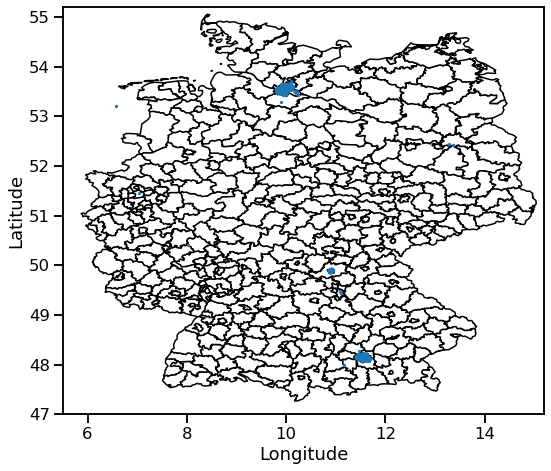

In [15]:
#Just plotting the campaigns
fig, ax = plt.subplots(figsize=(8,7))
kreise.plot(ax=ax, color='white', edgecolor='black')

ax.scatter(form['longitude'], form['latitude'], s=3)

ax.set_xlim(5.5, 15.2)
ax.set_ylim(47, 55.2)
ax.set_aspect(1)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

plt.savefig('./Figures/test1.png', dpi=300, )
plt.show()

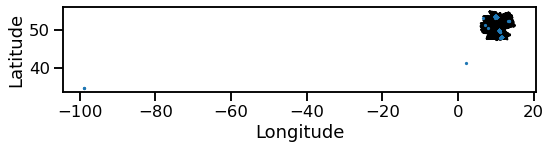

In [16]:
fig, ax = plt.subplots(figsize=(8,7))
kreise.plot(ax=ax, color='white', edgecolor='black')

ax.scatter(form['longitude'], form['latitude'], s=3)

#ax.set_xlim(5.5, 15.2)
#ax.set_ylim(47, 55.2)
ax.set_aspect(1)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

plt.savefig('./Figures/test2.png', dpi=300, )
plt.show()